In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import os

%matplotlib inline

In [4]:
class Line:
    # y = m * x + b
    def __init__(self,x1,y1,x2,y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.slope = self.compute_slope()
        self.b = self.compute_b()
        
    def compute_slope(self):
        return (self.y2-self.y1)/(self.x2-self.x1)
    
    def compute_b(self):
        return self.y1 - self.slope * self.x1
    
    def get_coords(self):
        return (self.x1,self.y1) , (self.x2,self.y2)

In [5]:
def region_of_interest(img,vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    
    mask = np.zeros_like(img)
    
    if len(img.shape) >2:
        mask_color = (255,) * img.shape[2]
    else:
        mask_color = 255
    
    cv2.fillPoly(mask,vertices,mask_color)
    masked_img = cv2.bitwise_and(mask,img)
    
    return masked_img

In [9]:
def canny(img,low_threshold,high_threshold):
    """Applies Canny Transform"""
    return cv2.Canny(img,low_threshold,high_threshold)

def gaussian_blur(img,kernal_size):
    """Applies Gaussian Noise Kernal"""
    return cv2.GaussianBlur(img,(kernal_size,kernal_size),0)

def get_right_left_lines(lane_lines,img_shape):
    
    right_lines = [l for l in lane_lines if l.slope > 0]
    left_lines = [l for l in lane_lines if l.slope < 0]

    # interpolate biases and slopes to compute equation of line that approximates left lane
    # median is employed to filter outliers
    lane_left_bias = np.median([l.b for l in left_lines]).astype(int)
    lane_left_slope = np.median([l.slope for l in left_lines])
    x1, y1 = 0, lane_left_bias
    x2, y2 = -np.int32(np.round(lane_left_bias / lane_left_slope)),0
    left_lane = Line(x1, y1, x2, y2)

    # interpolate biases and slopes to compute equation of line that approximates right lane
    # median is employed to filter outliers
    lane_right_bias = np.median([l.b for l in right_lines]).astype(int)
    lane_right_slope = np.median([l.slope for l in right_lines])
    x1, y1 = 0, lane_right_bias
    x2, y2 = np.int32(np.round((img_shape[0] - lane_right_bias) / lane_right_slope)), img_shape[0]
    right_lane = Line(x1, y1, x2, y2)
    
    return right_lane, left_lane


def get_lane_lines(img,solid_lane = True):
    """
    Return img with lane lines on it ready to weighted with orginal image
    
    Parms:
        img : source img
        
        solid_lane : if True find Two Lane lines ( left and right), False return all lane lines detected from Hough
        
    """
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    blur = gaussian_blur(gray,5)
    
    edges = canny(blur,75,150)
    
    imshape = img.shape
    vertices = np.array([[(50,imshape[0]),(450,320),(imshape[1]-450,320),(imshape[1]-50,imshape[0])]], dtype=np.int32)

    masked_edges = region_of_interest(edges,vertices)
    
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 30   # maximum gap in pixels between connectable line segments

    lane_lines = cv2.HoughLinesP(masked_edges, rho, theta,
                                 threshold, np.array([]),
                                 minLineLength=min_line_length,
                                 maxLineGap=max_line_gap)
   
    lane_lines = [Line(*l[0]) for l in lane_lines]
    if solid_lane:
        lane_lines = get_right_left_lines(lane_lines,img.shape)
    lane_img = np.zeros_like(img)
    for l in lane_lines:
        cv2.line(lane_img, l.get_coords()[0], l.get_coords()[1], [255,0,0], thickness=8)
    
    lane_img = region_of_interest(lane_img,vertices)
    
    return lane_img


def weighted_img(lane_img, initial_img, α=0.8, β=1., γ=0.):
    """
    `lane_img` is the output of the get_lane_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, lane_img, β, γ)

In [10]:
def test_images(images_path="data/test_images/",out_path="out/images/"):
    images_name = os.listdir(images_path)
    for img_name in images_name:
        img = mpimg.imread(images_path+img_name)
        lane_img = get_lane_lines(img)
        img = weighted_img(lane_img,img)
        plt.imsave(out_path+img_name,img)
        plt.imshow(img)
        plt.show()

def frame_process(frame):
    lane_img = get_lane_lines(frame)
    img = weighted_img(lane_img,frame)
    return img

def test_videos(videos_path="data/test_videos/",out_path="out/videos/",smooth = False):
    videos_name = os.listdir(videos_path)
    for video_name in videos_name:
        clip = VideoFileClip(videos_path+video_name,audio=False)
        if smooth:
            # TODO: implement smooth for videos frames
            #frames = []
            #temp = 0
            #for frame in clip.iter_frames():
            #if temp<5:
            #frames.append(frame)
            pass
        else:
            new_clip = clip.fl_image(frame_process)
        print(f"Writing video: {video_name} ... ")
        %time new_clip.write_videofile(out_path+video_name, audio=False)
        print(".........................")
        

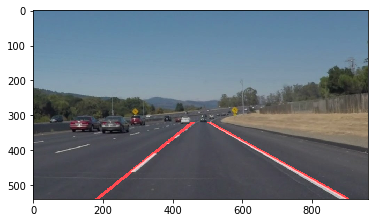

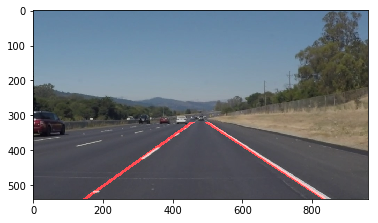

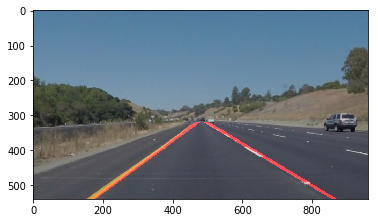

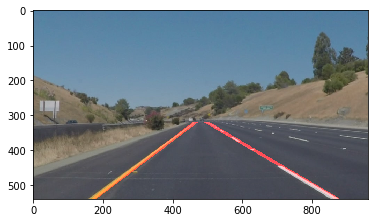

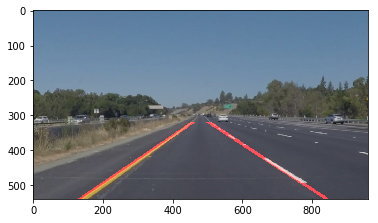

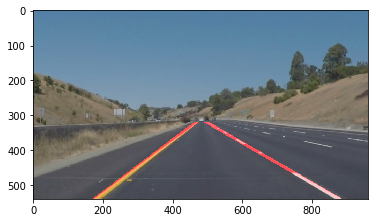

In [11]:
test_images()

In [12]:
test_videos()

Writing video: challenge.mp4 ... 
Moviepy - Building video out/videos/challenge.mp4.
Moviepy - Writing video out/videos/challenge.mp4



Moviepy - Done !
Moviepy - video ready out/videos/challenge.mp4
Wall time: 7.77 s
.........................
Writing video: solidWhiteRight.mp4 ... 
Moviepy - Building video out/videos/solidWhiteRight.mp4.
Moviepy - Writing video out/videos/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready out/videos/solidWhiteRight.mp4
Wall time: 3.14 s
.........................
Writing video: solidYellowLeft.mp4 ... 
Moviepy - Building video out/videos/solidYellowLeft.mp4.
Moviepy - Writing video out/videos/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready out/videos/solidYellowLeft.mp4
Wall time: 9.33 s
.........................
